# Blind Source Separation of IR Spectra

**Authors**: Aaron Liu, Rahul Venkatesh, Martha Grover, Carson Meredith, Elsa Reichmanis

The methodology and code adopted here is heavily influenced by the following work:

G. Maggioni, S. Kocevska, M. Grover, R. Rousseau. *Ind. Eng. Chem. Res.* **2019**, 58, 22640−22651


## Context

Here, we aim to analyze the heat stability of KP3340, which is a thermoplastic polyester elastomer. Engineering plastics commonly undergo degradation of their mechanical properties when exposed to high temperatures for an extended period of time. Many end-user applications, such as automotive uses, require mechanical robustness at elevated temperatures under both ambient conditions and in other harsh environments such as grease exposure. In order to provide *heat* and *grease stability*, it is of interest to investigate the use of additives to mitigate degradation due to impurities and thermal exposure. Specifically, in this project the following metrics are desired:

<img src="img/kopel-metrics.png" alt="Drawing" style="width: 800px;"/>

where **stability** is quantified as a percentage of the observed mechanical property before and after the exposure conditions.

\begin{align*}
  y = \frac{\text{UTS after heat treatment}}{\text{UTS before heat treatment}} (100\%)
\end{align*}

\begin{align*}
  y = \frac{\text{elongation after heat treatment}}{\text{elongation before heat treatment}} (100\%)
\end{align*}

The extent of degradation may be probed through spectroscopic methods, such as ATR-FTIR. By using the Beer-Lambert law, we assume that the signal of any chemical species is linearly proportional to concentration. 

\begin{align*}
  X = CL
\end{align*}

Where $X$ is the matrix of measured spectra, $C$ is the matrix of concentrations, and $L$ is the matrix containing the spectra of pure species. The total signal can be depicted as a linear combination of the intensities of these different species, or **sources**. For example, in additive-containing KP3340 samples, the spectra might be a linear combination of stable modes and degraded modes. However, in many cases there is limited available information about the chemical system; in other words, we may not know what peaks or characteristics correspond to a degraded mode ($L$ is unknown). **Blind Source Separation** (BSS) refers to a set of techniques that attempts to identify an approximate solution in the form of:

\begin{align*}
  X = AS
\end{align*}

where $A$ is a mixing matrix likened to $C$ and $S$ is an approximate "sources" matrix, which can be seen as an approximation of chemical components. Here, BSS can potentially identify degradation modes, and heat stability could then be correlated to those modes. 

## Objectives

* Use Blind Source Separation techniques to identify features in IR spectra for analysis
* Demonstrate basic machine learning (ML) analysis using the discovered features

A major motif that has been demonstrated in this project is facilitating the quantitative representation of chemical data. In our parallel work with patent data for PET additives, we have demonstrated that molecular descriptors can be used to facilitate the representation of molecular structures. However, chemical structure data such as spectroscopic data is often high-dimensional. Using latent variable methods not only can reduce the dimensionality for a further data analysis **without significant information loss**, but also potentially highlight the signal sources that may be related to degradation. These sources can then be used as features to analyze for heat stability.


## Dataset Details

Unfortunately, due to the COVID-19 circumstances, our ability to collect a large database of spectra for this demonstration is limited. While the sample size of our dataset is small, we hope to present this workbook as an illustration of how latent variable techniques can be applied to facilitate machine learning (ML) algorithms to predict new data based on desired metrics.

KP3340/additive blends were solution processed under a controlled composition in chloroform. Film samples were then blade cast onto a glass substrate coated with a water soluble sodium polystyrene sulfonate (NaPSS) release layer. Films were then recovered by submerging the substrate in water to remove the release layer, allowed to vacuum dry at ambient temperatures, and then subjected to 1 day of heat treatment in air inside an oven at 165$^{\circ}$C. After the allotted time, samples were removed from the oven and subjected to biaxial mechanical property testing (HTMECH) and ATR-FTIR spectra measurements. 

In total, this dataset contains 16 spectra from 11 total samples. One sample film was KP3340 with no additive, and five samples (compositions of 0.1%, 0.5%, 1.0%, 2.0%, and 5.0% by weight of additive) consisted of samples containing Irganox 1010 and Irganox 1076. IR measurements were taken of all 11 of these samples after 1 day of heating. For 5 samples (Irganox 1010), spectra were also measured prior to any heat exposure (5 'before heating' + 11 'after heating' = 16 total spectra)

## Analysis of IR Spectra

### Import Python Packages

In [1]:
%matplotlib inline
#Import required modules
import numpy as np
import pandas as pd
import scipy, glob, os, fnmatch, re, time, sys
import matplotlib.pyplot as plt
from numpy import matlib

np.set_printoptions(suppress=True,precision=4)

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

Import analytics packages. FastICA and pymcr can be installed using pip and conda commands, respectively.

In [2]:
# ! pip install FastICA
# ! pip install pymcr

from sklearn.decomposition import FastICA
from sklearn import linear_model
from joblib import Parallel, delayed
from pymcr.mcr import McrAR
from pymcr.constraints import ConstraintNonneg

### Database Import and Pre-processing

Load dataframe, and set data attributes for file permissions:

In [3]:
#Load data from file
df = pd.read_excel("Data/KP3340-Irganox-IR-only.xlsx",sheet_name='All Data')
class Data:
    pass
IoSControl = Data
setattr(IoSControl,'w',df.values[106:,0]);
setattr(IoSControl,'I',df.values[106:,1:]);

df

,Additive Trade Name,Heat Exposure (days),Additive wt%,499.563344,501.49216,503.420976,505.349792,507.278608,509.207424,511.13624,...,3983.00504,3984.933856,3986.862672,3988.791488,3990.720304,3992.64912,3994.577936,3996.506752,3998.435568,4000.364384
0,None,1,0.0,0.001574,-0.008615,-0.013144,-0.014446,-0.013462,-0.008627,-0.008214,...,-0.000322,-0.000504,-0.000525,-0.000304,-0.000044,-0.000165,-0.000185,-0.000399,-0.000632,-0.000634
1,Irganox 1010,1,0.1,-0.020884,-0.032902,-0.032511,-0.021091,-0.010239,-0.010363,-0.012014,...,-0.000434,-0.000540,-0.000568,-0.000444,-0.000280,-0.000316,-0.000319,-0.000415,-0.000581,-0.000633
2,Irganox 1010,1,0.5,-0.016778,-0.020651,-0.016651,-0.014954,-0.012421,-0.008717,-0.006492,...,-0.002887,-0.002938,-0.002933,-0.002860,-0.002793,-0.002812,-0.002781,-0.002821,-0.002934,-0.003002
3,Irganox 1010,1,1.0,-0.033936,-0.035274,-0.035229,-0.032244,-0.027316,-0.022458,-0.021121,...,-0.007082,-0.007277,-0.007338,-0.007090,-0.006759,-0.006843,-0.006935,-0.007167,-0.007460,-0.007525
4,Irganox 1010,1,2.0,0.013193,0.003559,0.001011,0.000528,0.000717,0.010572,0.010461,...,-0.004054,-0.004107,-0.004186,-0.004170,-0.004080,-0.004042,-0.004013,-0.004012,-0.004077,-0.004157
5,Irganox 1010,1,5.0,-0.012043,-0.017681,-0.016611,-0.013555,-0.008087,-0.000685,-0.000166,...,-0.007227,-0.007446,-0.007455,-0.007217,-0.006969,-0.007078,-0.007118,-0.007334,-0.007566,-0.007600
6,Irganox 1076,1,0.1,-0.020896,-0.022680,-0.021061,-0.008304,0.001235,0.003545,0.003756,...,-0.016661,-0.016571,-0.016580,-0.016630,-0.016604,-0.016540,-0.016589,-0.016711,-0.016695,-0.016637
7,Irganox 1076,1,0.5,-0.003468,-0.001175,-0.003928,-0.004872,-0.003334,-0.001915,-0.003048,...,-0.017538,-0.017468,-0.017473,-0.017431,-0.017435,-0.017380,-0.017326,-0.017453,-0.017541,-0.017610
8,Irganox 1076,1,1.0,-0.006101,-0.008820,-0.003504,0.010876,0.015135,0.007083,0.004885,...,-0.022600,-0.022560,-0.022569,-0.022620,-0.022590,-0.022500,-0.022478,-0.022586,-0.022651,-0.022702
9,Irganox 1076,1,2.0,-0.001096,-0.002468,0.001622,0.012042,0.018591,0.011878,0.006528,...,-0.021799,-0.021751,-0.021801,-0.021771,-0.021708,-0.021679,-0.021729,-0.021858,-0.021897,-0.021949


In [4]:
# Define the input vectors
wavenumber  = df.columns[108:1402].values.astype(np.float)   # wavenumbers
Xo = df.values[:,108:1402].astype(np.float) # spectra/Absorbance intensity
Xraw = Xo*1 #create a raw copy for comparison

# Xo = 2-np.log10(Xo)
print(Xo.shape)
print(wavenumber.shape)

(16, 1294)
(1294,)


### Baselining

Baselining is achieved through airPLS.py from Zhang et al. (2010), which can be downloaded via github: https://github.com/zmzhang/airPLS. Reference information: 

*Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).*

Text(0.5, 1.0, 'After Baselining')

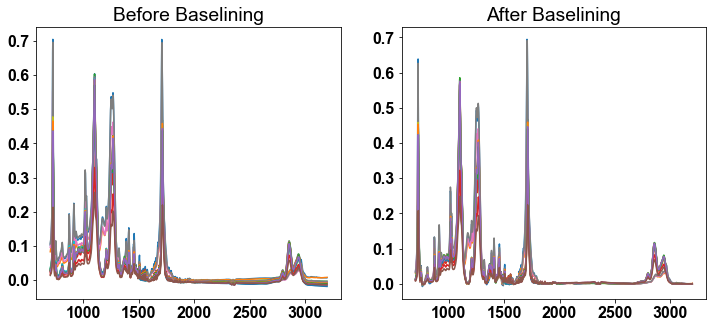

In [5]:
from airPLS import airPLS

# Baseline the data
def baselining(arg):
    
    wavenumber,X = arg

    est = airPLS(X,itermax=1000)

    return  X-est

par_arg = [(wavenumber, Xo[p,:]) for p in range(0,Xo.shape[0])]            
I = Parallel(n_jobs=-1, verbose=0, backend="threading")(
        map(delayed(baselining), par_arg));
Xo = np.asarray(I);

#Plot before/after baselining for comparison
fig, ax = plt.subplots(1,2,figsize=(12,5))
for i in range(Xo.shape[0]):
    ax[0].plot(wavenumber,Xraw[i,:])
    ax[1].plot(wavenumber,Xo[i,:])
    
ax[0].set_title('Before Baselining')
ax[1].set_title('After Baselining')

In [6]:
# Define some copies of the baselined data for convenience
Xe = 1*Xo;
X0 = 1*Xo

# store indices
index = range(0,Xo.shape[0])

### Signal Pre-processing

In [7]:
from scipy import signal

"""
Pre-processing: Used for ICA
"""

# Mean of each spectrum
mu = X0.mean(1)

#Set scaling type
scaling = 1;    # Type of Scaling

# square root of the standard deviation, before subtracting the mean
si = np.sqrt(X0.std(1))
for i in range(X0.shape[0]):      
     # Scaling, according to 
    if scaling == 0: # Autoscaling
        X0[i,:] = ( X0[i,:]-mu[i] )/si[i]**2
    elif scaling == 1: # Pareto scaling
        X0[i,:] = ( X0[i,:]-mu[i] ) / si[i] 
    elif scaling == 2: # Vast Scaling
        X0[i,:] = ( X0[i,:]-mu[i] )/(si[i] **2)*(mu[i]/(si[i] **2))
    elif scaling == 3: #   
        X0[i,:] /= np.trapz(X0[i,:],wavenumber); 
    elif scaling == 4: #  
        X0[i,:] = ( X0[i,:] ) / si[i]
    elif scaling == 5: #  
        X0[i,:] = ( X0[i,:] )  
        
# Estimation of Average SNR, Noise directly estimated from device used
SNR = Xo.var(1).mean()/100**2
# Local index of the SNR 
SNRi = (Xo**2)/(((Xo**2).mean())/SNR)
# Estimate the amount of noise
EstCovNoise = (Xo**2).mean()/SNR;

In [8]:
"""
Set Options for the Savitzky-Golay smoothing
"""
DerOrd  = 2;    # Derivative Order of the Spectrum
SGpol   = 2     # Interpolant Polynomial Degree
SGw     = 15;   # Number of points per Window


# Compute the SG - Derivatives of the mixed signals
Xd = X0*1.
XoSG = np.empty(Xo.shape);
for kk in range(X0.shape[0]):#range(0,X0.shape[0]):
    XoSG[kk,:] = scipy.signal.savgol_filter(Xo[kk,:], 9, SGpol, deriv=0, mode='nearest');
    j = 1;
    while j<=DerOrd:
        Xd[kk,:]   = scipy.signal.savgol_filter(Xd[kk,:], SGw, SGpol, deriv=1, mode='nearest');
        j +=1

### Singular Value Decomposition (SVD)
SVD can be used to determine the number of independent components to be used. The relative magnitudes of diagonal values (eigenvalues) in the $S$ matrix are used to compute the effective rank.

In [9]:
"""
Determination of the number of Components via SVD
"""
Xnica = 1.*Xo[index,:]
U, Sv, V = np.linalg.svd( Xnica, full_matrices=True)
S = np.zeros(Xnica.shape)
np.fill_diagonal(S[:Xnica.shape[0],:Xnica.shape[1]],Sv)
N = abs(Xnica).sum(1)

def nica_parallel(arg):
    
    X,Rec,N = arg
    E = max(abs(Xnica-Rec).sum(1)/N) 
    E = abs(Xnica-Rec).mean(1).max()
    return  E

par_arg = [(Xnica, U@S[:,0:nn+1]@V[0:nn+1,:],N) for nn in range(0,Xnica.shape[0])]            
I = Parallel(n_jobs=-1, verbose=0, backend="threading")(
        map(delayed(nica_parallel), par_arg));
E = np.asarray(I);
DE = np.append(-E[0],np.diff(E)) 

EstErr = 2.7e-3 # based on the average estimated error
nica = np.where(E<=EstErr)[0][0]

print('Total number of components from SVD: {}'.format(nica))

Total number of components from SVD: 2


### **Principal Component Analysis (PCA)**: 
PCA maximizes the variance across the input data (this is unsupervised; i.e. not considering heat stability values)

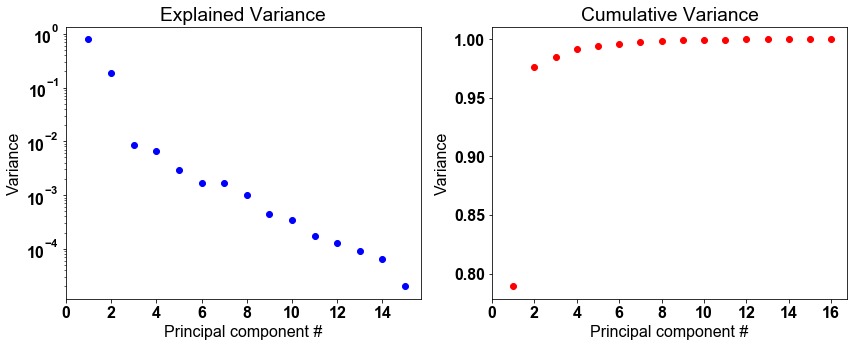

In [10]:
from sklearn.decomposition import PCA
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

## Apply principal component analysis on the scaled set
pca = PCA()
pca.fit_transform(X0)
fig, ax = plt.subplots(1,2,figsize=(14,5))

# Plots
N = pca.explained_variance_ratio_.shape[0]
ax[0].semilogy(1+np.arange(N-1), pca.explained_variance_ratio_[:-1], 'bo', label="Explained variance")
ax[1].plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), 'ro', label="Cumulative variance")
ax[0].set(xlabel='Principal component #', ylabel='Variance',title='Explained Variance')
ax[1].set(xlabel='Principal component #', ylabel='Variance',title='Cumulative Variance');
ax[0].set_xticks(np.arange(0, N, 2.0));
ax[1].set_xticks(np.arange(0, N+1, 2.0));

**Discussion:** Here, we see that variance explained drops off dramatically between 2 and 3 principal components. This should be similar to the result from SVD above.

### **Independent Component Analysis (ICA)**: 
While PCA maximizes the variance (second moment) across the dataset, ICA maximizes based on kurtosis (fourth moment) of the peaks 

In [11]:
"""
FastICA
"""
tic = time.time()
# Compute ICA
ica = FastICA(n_components=nica,tol=1e-8,max_iter=500)
ica.fit_transform(Xd[index,:].T)  # Reconstruct signals, needs the transpose of the matrix
A_ = ica.mixing_  # Get estimated miXeg matrix
toc = time.time()
runningtime_fastica = toc-tic # How long the decomposition took

shift = np.linalg.pinv(A_)@(mu[index,].reshape(-1,1)/si[index,].reshape(-1,1));

S0ica = (np.linalg.pinv(A_)@X0[index,:]) + shift # Reconstruct signals, needs the transpose of the matrix
Sdica = (np.linalg.pinv(A_)@Xd[index,:])  # Reconstruct signals, needs the transpose of the matrix
A_ *= si[index,].reshape(-1,1)
Aica = A_*1.

### **Multivariate Curve Resolution with Alternating Least Squares**: 
The MCR-ALS method goes a bit further in providing chemical interpretability, and the method applies constraints that may be applicable to a real chemical system. For example, some applicable constraints to spectra might be non-negativity, unimodality, etc.

In [12]:
tic = time.time()
#mcrals = McrAR(c_regr='NNLS',max_iter=700,tol_err_change=Xo[index,:].max()*1e-8,st_regr='NNLS',c_constraints=[ConstraintNonneg()])
mcrals = McrAR(st_regr='NNLS',c_regr=linear_model.ElasticNet(alpha=1e-4,l1_ratio=0.75),tol_increase=5,tol_n_above_min=500,max_iter=2000,tol_err_change=Xnica.mean()*1e-8,c_constraints=[ConstraintNonneg()])
mcrals.fit(Xo[index,:], ST= S0ica**2 )
toc = time.time()
runningtime_mcrals = toc-tic # How long the decomposition took

S0mcr = mcrals.ST_opt_;
Amcr  = mcrals.C_opt_; 
Sdmcr = (np.linalg.pinv(Amcr)@Xd[index,:])


### Results: Source Visualization with Plots

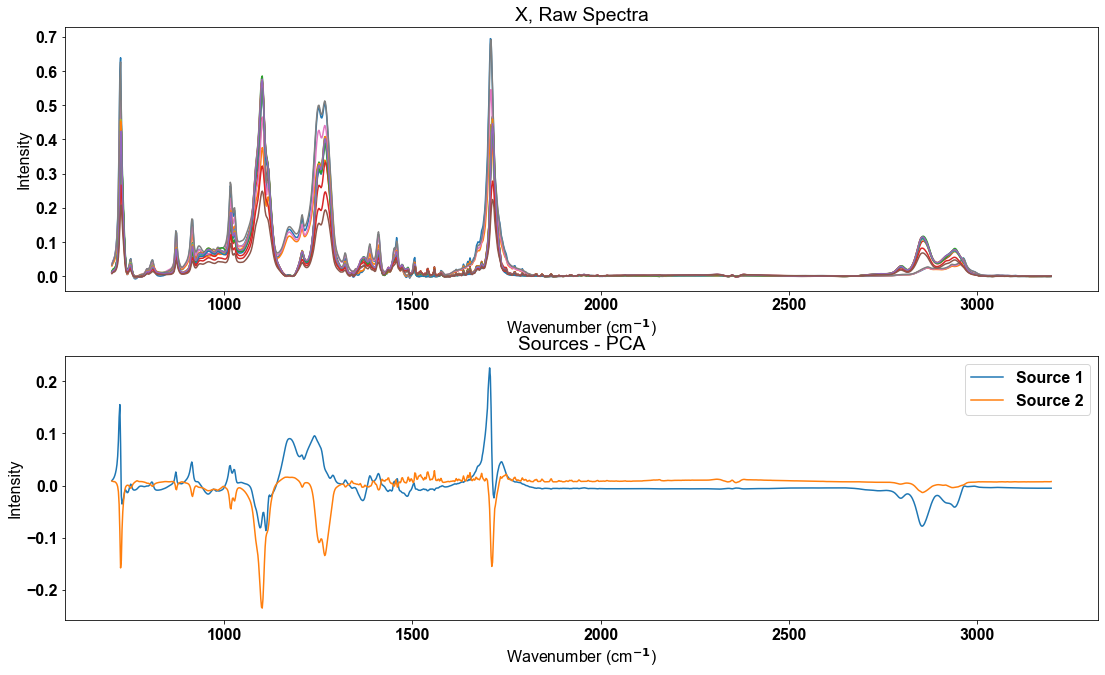

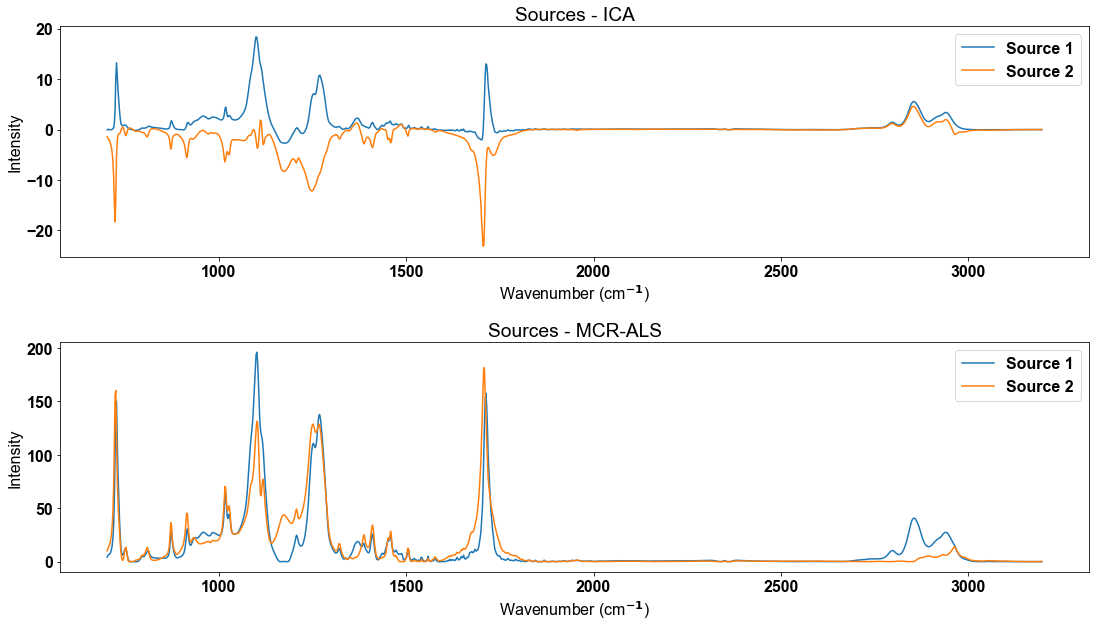

In [13]:
# Final Results
fig = plt.figure(4)
fig.set_size_inches(15.5, 9)

#Raw spectra
plt.subplot(2,1,1)  
plt.title('X, Raw Spectra') 
plt.plot(wavenumber,Xe[index,:].T)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity')
plt.tight_layout()
#PCA Sources
plt.subplot(2,1,2)
plt.title('Sources - PCA')
for i in range(nica):
    plt.plot(wavenumber,pca.components_[i])
plt.legend(['Source 1','Source 2'])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity')

fig = plt.figure(5)
fig.set_size_inches(15.5, 9)

#ICA Sources
plt.subplot(2,1,1)  
plt.title('Sources - ICA')  
plt.plot(wavenumber,S0ica.T)
plt.legend(['Source 1','Source 2'])
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity')

#MCR-ALS Sources
plt.subplot(2,1,2)
plt.title('Sources - MCR-ALS')  
plt.plot(wavenumber,S0mcr.T)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity')
plt.legend(['Source 1','Source 2']);
plt.tight_layout()

**Discussion:** The MCR-ALS sources perhaps most resemble actual chemical modes, with higher components beyond Source 3 bearing more resemblance of noise.

Comparing the raw spectra and the MCR-ALS sources, it can be observed that Component 1 most resembles a sample more stabilized by its additive, whereas Source 2 more resembles a degraded sample. This could be a promising sign that blind source separation techniques can identify chemical modes, but it would be easier to justify this with more data. As we can see from the *Raw Spectra* plot above, visual inspection of the C=O peak broadening (1700 $cm^{-1}$) and C-H degradation (2800-3000 $cm^{-1}$) can clearly distinguish those samples that contain less effective additive compositions. More intermediate behavior would be useful in order to conclude that these blind sources are reliable data representations. 

## Correlation to Heat Stability

Now that we have identified a set of blind sources, we would ideally be able to correlate the weights of those blind sources to actual properties of interest, such as mechanical property persistence (i.e. **heat stability**). Unfortunately, we do not have the ability to obtain additional laboratory data for this purpose. However, we can demonstrate exploratory data analysis and basic techniques here.

In [14]:
#Import the file containing the heat stability data
df_y = pd.read_csv('Data\KP3340_ATRFTIR_1dayheated-database-noIR.csv')

# Assign classification labels based on whether or not the elongation after 1 day of heat exposure is greater than 50%
df_y['label'] = (df_y['Heat Stability Elong (165C-1day) %'] > 50)
y = df_y['Heat Stability Elong (165C-1day) %'].values
label = df_y['label'].values

df_y


,Additive Trade Name,Additive wt%,HTMECH UTS (No Heat),HTMECH Elong (No Heat),HTMECH UTS (1d),HTMECH Elong (1d),Heat Stability UTS (165C-1day) %,Heat Stability Elong (165C-1day) %,label
0,None,0.0,8.20,4.20,0.00,0.0000,0.00,0.00,False
1,Irganox 1010,0.1,6.90,3.20,8.40,0.0123,121.74,0.38,False
2,Irganox 1010,0.5,7.50,4.00,6.60,2.7000,88.00,67.50,True
3,Irganox 1010,1.0,6.17,2.40,6.35,2.3700,102.92,98.75,True
4,Irganox 1010,2.0,6.72,2.90,6.42,3.7900,95.54,130.69,True
5,Irganox 1010,5.0,7.30,4.10,7.08,5.3000,96.99,129.27,True
6,Irganox 1076,0.1,5.98,3.42,5.35,0.0130,89.46,0.38,False
7,Irganox 1076,0.5,5.12,3.27,11.33,0.0700,221.29,2.14,False
8,Irganox 1076,1.0,5.97,3.12,6.50,2.1000,108.88,67.31,True
9,Irganox 1076,2.0,6.20,4.00,6.10,3.5200,98.39,88.00,True


Here, a classification label of 'high' or 'low' performance was assigned based on whether or not the 1-day heat stability (elongation) was greater than 50%, as guided by the project metrics.

In [15]:
from sklearn.model_selection import train_test_split

#We will only train our model on the spectra that were taken after heat exposure. These have been already baselined
Xo = X0[:11,:] #These are the first 11 rows in the file

# Define some copies of the baselined data for convenience
Xe = 1*Xo
X0 = 1*Xo
Xnica = 1*Xo


In [16]:
def construct_BSS_models(Xo, y):
    
    
    # Define some copies of the baselined data for convenience
    Xe = 1*Xo
    X0 = 1*Xo
    Xnica = 1*Xo
    
    # store indices
    index = range(0,X0.shape[0])
    
    
    # For demonstration, set 2 components
    nica = 2

    # Apply principal component analysis on the scaled set
    pca = PCA()
    pca.fit_transform(X0)
    Apca = pca.transform(X0)[:,:2]
    S0pca = pca.components_[:2,:]

    # Compute ICA
    Xd = X0*1.
    XoSG = np.empty(X0.shape);
    for kk in range(X0.shape[0]):#range(0,X0.shape[0]):
        XoSG[kk,:] = scipy.signal.savgol_filter(X0[kk,:], 9, SGpol, deriv=0, mode='nearest');
        j = 1;
        while j<=DerOrd:
            Xd[kk,:]   = scipy.signal.savgol_filter(Xd[kk,:], SGw, SGpol, deriv=1, mode='nearest');
            j +=1
    ica = FastICA(n_components=nica,tol=1e-8,max_iter=500)
    ica.fit_transform(Xd[index,:].T)  # Reconstruct signals, needs the transpose of the matrix
    A_ = ica.mixing_  # Get estimated miXeg matrix
    
    mu = X0.mean(1)
    si = np.sqrt(X0.std(1))
    shift = np.linalg.pinv(A_)@(mu[index,].reshape(-1,1)/si[index,].reshape(-1,1));
    S0ica = (np.linalg.pinv(A_)@X0[index,:]) + shift # Reconstruct signals, needs the transpose of the matrix
    Sdica = (np.linalg.pinv(A_)@Xd[index,:])  # Reconstruct signals, needs the transpose of the matrix

    A_ *= si[index,].reshape(-1,1)
    Aica = A_*1.

    # Compute MCR-ALS
    mcrals = McrAR(st_regr='NNLS',c_regr=linear_model.ElasticNet(alpha=1e-4,l1_ratio=0.75),tol_increase=5,tol_n_above_min=500,max_iter=2000,tol_err_change=Xnica.mean()*1e-8,c_constraints=[ConstraintNonneg()])
    mcrals.fit(X0[index,:], ST= S0ica**2 )
    S0mcr = mcrals.ST_opt_;
    Amcr  = mcrals.C_opt_; 
    
    return Apca, Aica, Amcr, S0pca, S0ica, S0mcr

In [17]:
# Perform a validation split
np.random.seed(90) #for consistency
Xo, X_val, yo, y_val = train_test_split(X0, y, test_size=0.2,stratify=label) #Make sure that the class labels are distributed

# yo = y
# Xo = X0

yo_values = yo
yo = yo > 50

Apca, Aica, Amcr, S0pca, S0ica, S0mcr = construct_BSS_models(Xo, yo)

In [18]:
#For convenience, make some copies of the source coefficients found previously, up to 2 components

cmp_x = 0
cmp_y = 1

# Get PCA component weights
PCA1 = Apca[:,cmp_x]
PCA2 = Apca[:,cmp_y]

# MCR-ALS Source Weights
MCR1 = Amcr[:,cmp_x]
MCR2 = Amcr[:,cmp_y]

# ICA weights
ICA1 = Aica[:,cmp_x]
ICA2 = Aica[:,cmp_y]

# labels
label = yo
# yo = yo*1

plt.rc('image', cmap='coolwarm') #set colormap
cmap = plt.cm.get_cmap('coolwarm')

### Demonstration with Elongation Persistence
We can use one of the columns of interest to correlate to some of the blind source coefficients. First, we observe the sources vs. the elongation persistence after one day at $165^oC$:

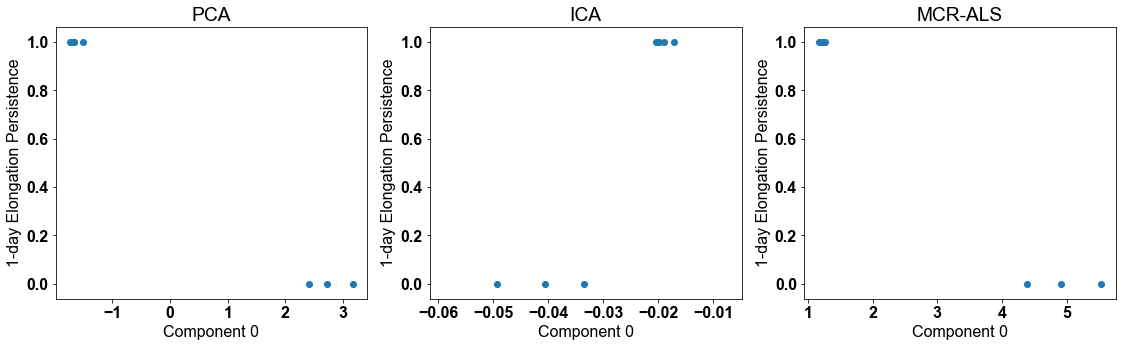

In [19]:
# #Set property of interest here:
# col_str = df_y.columns[7] #Elongation after one day of heating at 165 C
# y = df_y[col_str]

fig, ax = plt.subplots(1,3,figsize=(19,5))

ax[0].scatter(PCA1, yo*1)
ax[1].scatter(ICA1, yo*1)
ax[2].scatter(MCR1, yo*1)

ax[0].set(ylabel='1-day Elongation Persistence', xlabel = 'Component {}'.format(cmp_x), title='PCA')
ax[1].set(ylabel='1-day Elongation Persistence', xlabel = 'Component {}'.format(cmp_x), title="ICA")
ax[2].set(ylabel='1-day Elongation Persistence', xlabel = 'Component {}'.format(cmp_x), title='MCR-ALS');

From just plotting the components vs. the property value of interest, there isn't a clear correlation anywhere. However, by assigning labels based on whether or not samples meet the threshold criteria (>50% elongation persistence after heating), there is clear class separation:

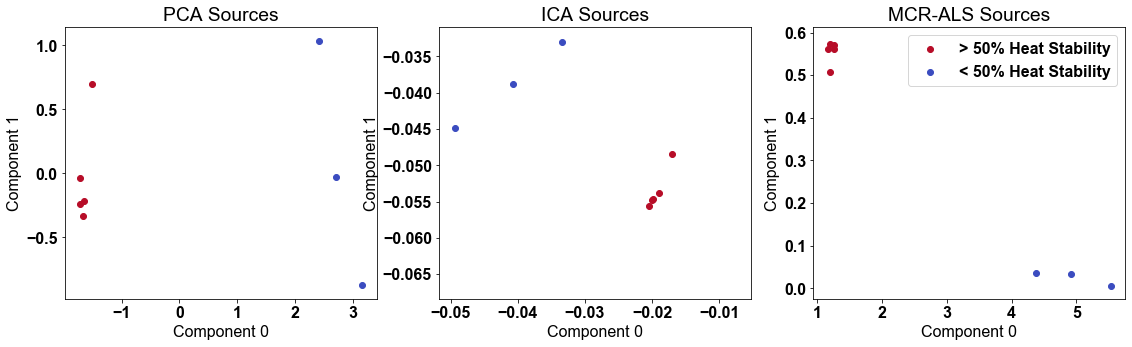

In [20]:
fig, ax = plt.subplots(1,3,figsize=(19,5))

ax[0].scatter(PCA1[label], PCA2[label], c=[cmap(0.99)])
ax[0].scatter(PCA1[~label], PCA2[~label], c=[cmap(0.)])

ax[1].scatter(ICA1[label], ICA2[label], c=[cmap(0.99)])
ax[1].scatter(ICA1[~label], ICA2[~label], c=[cmap(0.)])

ax[2].scatter(MCR1[label], MCR2[label], c=[cmap(0.99)])
ax[2].scatter(MCR1[~label], MCR2[~label], c=[cmap(0.)])

ax[0].set(ylabel='Component {}'.format(cmp_y), xlabel = 'Component {}'.format(cmp_x), title='PCA Sources')
ax[1].set(ylabel='Component {}'.format(cmp_y), xlabel = 'Component {}'.format(cmp_x), title="ICA Sources")
ax[2].set(ylabel='Component {}'.format(cmp_y), xlabel = 'Component {}'.format(cmp_x), title='MCR-ALS Sources')

ax[2].legend(['> 50% Heat Stability','< 50% Heat Stability']);


Above, it is relatively easy to distinguish between points that are above and below the 50% cutoff using the relative weights of the sources considered.

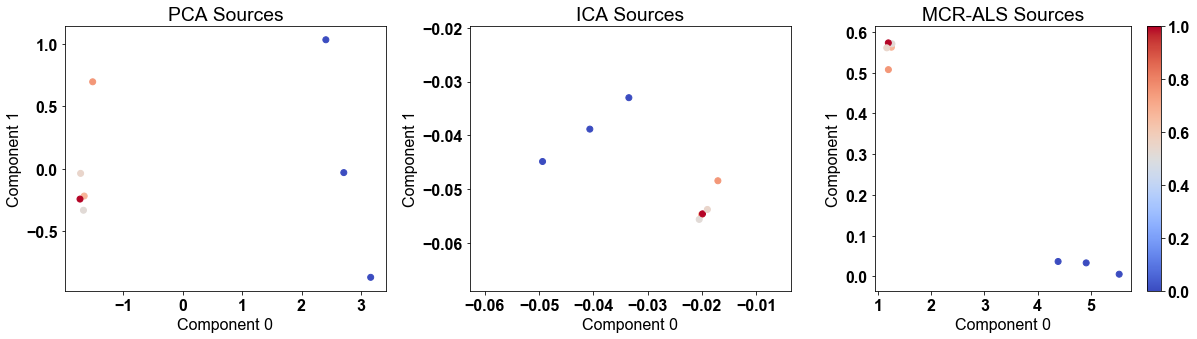

In [21]:
fig, ax = plt.subplots(1,3,figsize=(17,5))

ax[0].scatter(PCA1, PCA2, c=yo_values)
ax[1].scatter(ICA1, ICA2, c=yo_values)
im = ax[2].scatter(MCR1, MCR2, c=yo_values/np.max(yo_values))


ax[0].set(ylabel='Component {}'.format(cmp_y), xlabel = 'Component {}'.format(cmp_x), title='PCA Sources')
ax[1].set(ylabel='Component {}'.format(cmp_y), xlabel = 'Component {}'.format(cmp_x), title="ICA Sources")
ax[2].set(ylabel='Component {}'.format(cmp_y), 
          xlabel = 'Component {}'.format(cmp_x), 
          title='MCR-ALS Sources',
          # xlim=(-0.001,0.004), 
          # ylim=(-0.001,0.004)
          )
fig.colorbar(im)
plt.tight_layout()


Looking at the the plot again but with the raw heat stability values visualized, we see that it's easy to distinguish a class between 'high' and 'low', but there may not be enough data to draw intermediate behavior.

### Classification Model Construction

Since the data above is linearly separable, it should be a relatively simple process to apply a classifier to discern a decision boundary. One reason this might be useful is to save time from performing mechanical property experiments. Suppose that an experimentalist went through the process of testing 20 different new KP3340/additive film formulations (different additives, or different compositions), exposing them to the standard heat treatment. To collect the mechanical measurements for these samples would take a very long time, even multiple days, especially as mechanical measurements require a healthy number of replicates to instill confidence in the results. Instead, FTIR measurements can take a matter of seconds to perform per sample. If features can be identified from FTIR, they can automatically be screened through a classifier such that the samples below the 50% heat stability threshold do not need to be considered for further development.

In [22]:
from sklearn.svm import SVC # "Support vector classifier"


#PCA Model
model_pca = SVC(kernel='linear', gamma=1, C=1e9) #We choose hyperparameters with a little bit of constraint--data above looks linearly separable
model_pca.fit(Apca, yo)
y_predict_pca = model_pca.predict(Apca)

#MCR Model
model_ica = SVC(kernel='linear', gamma=1, C=1e9)
model_ica.fit(Aica, yo)
y_predict_ica = model_ica.predict(Aica)

#MCR Model
model_mcr = SVC(kernel='linear', gamma=1, C=1e9)
model_mcr.fit(Amcr, yo)
y_predict_mcr = model_mcr.predict(Amcr)

Text(0, 0.5, 'MCR Component 2')

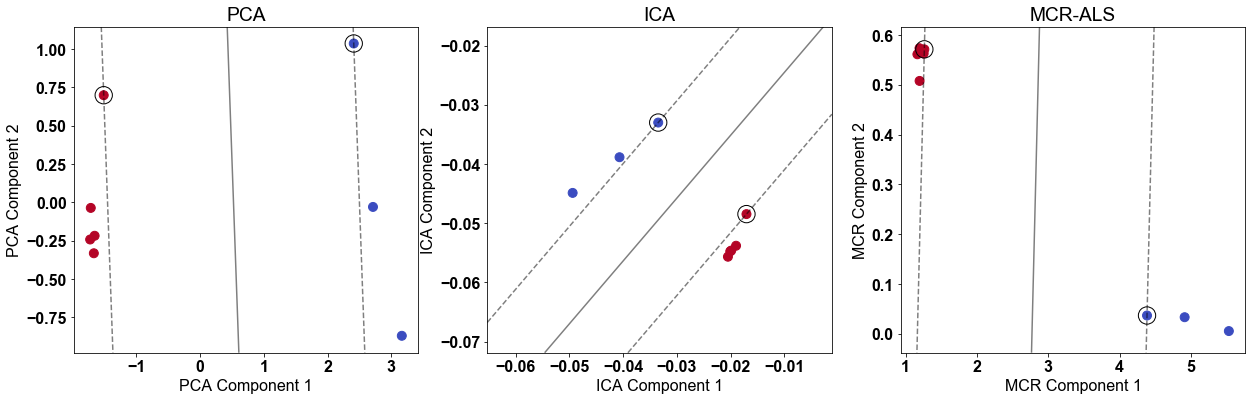

In [23]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if plot_support:
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0],
               model.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none', edgecolors='k');
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, ax = plt.subplots(1,3,figsize=(21,6))

ax[0].scatter(Apca[:, 0], Apca[:, 1], c=y_predict_pca, s=80)
plot_svc_decision_function(model_pca,ax=ax[0])
ax[0].set_title('PCA')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')

ax[1].scatter(Aica[:, 0], Aica[:, 1], c=y_predict_ica, s=80)
plot_svc_decision_function(model_ica,ax = ax[1])
ax[1].set_title('ICA')
ax[1].set_xlabel('ICA Component 1')
ax[1].set_ylabel('ICA Component 2')

ax[2].scatter(Amcr[:, 0], Amcr[:, 1], c=y_predict_mcr, s=80)
plot_svc_decision_function(model_mcr, ax = ax[2])
ax[2].set_title('MCR-ALS')
ax[2].set_xlabel('MCR Component 1')
ax[2].set_ylabel('MCR Component 2')
# ax[2].set(xlim=(-0.001,0.004), ylim=(-0.001,0.004));

### Cross Validation

Before any of the models above (PCA, ICA, MCR-ALS) were constructed, 20% of the original data was set aside for cross-validation. We will perform cross-validation here for demonstration:

In [24]:
# Recall the validation data that was not used to fit any of the latent models

print('Baselined Spectra for Cross-Validation: {}'.format(X_val.shape))
print('Labels for validation data (based on 50% heat stability threshold): {}'.format((y_val>50)*1))

Baselined Spectra for Cross-Validation: (3, 1294)
Labels for validation data (based on 50% heat stability threshold): [1 0 1]


To reiterate, the spectra were previously baselined, and spans the same range of wavenumbers as the original data (3 observations, 1,294 wavenumbers). The class labels are again based on whether the target met the desired metrics; points >50% heat stability are "high" performers (1), the rest are "low" performers (0).

In [25]:
#Transform test data into latent variable space
Apca_val = (np.linalg.pinv(S0pca.T)@X_val.T).T
Aica_val = (np.linalg.pinv(S0ica.T)@X_val.T).T
Amcr_val = (np.linalg.pinv(S0mcr.T)@X_val.T).T

print('Shape of transformed validation data: {}'.format(Apca_val.shape))

Shape of transformed validation data: (3, 2)


**Recall:** Each model yields an approximate solution $X = AS$

The source matrix $S$ is used to transform the new validation data ($X$) from raw spectra (high dimension) to latent space (low dimension). $A^T = (S^T)^{-1}X^T$

Text(0, 0.5, 'MCR Component 2')

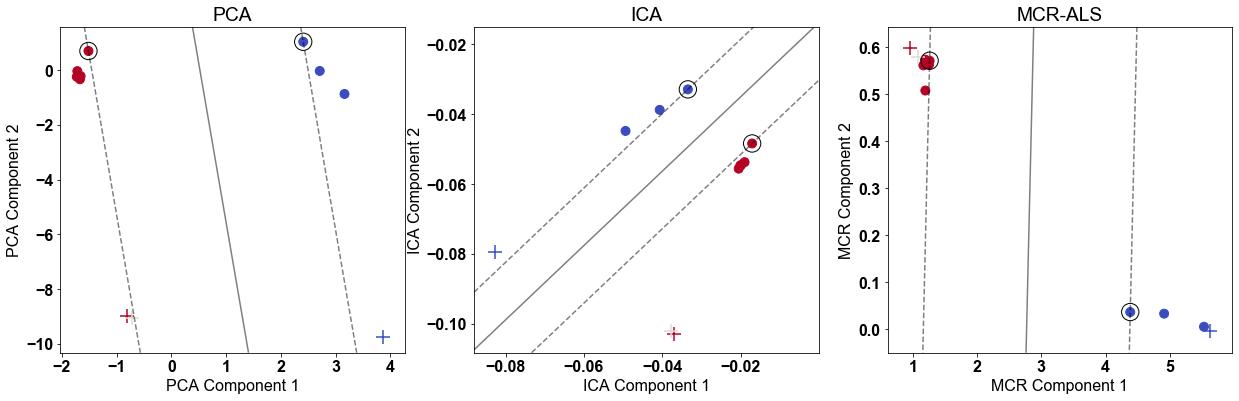

In [26]:
fig, ax = plt.subplots(1,3,figsize=(21,6))

ax[0].scatter(Apca[:, 0], Apca[:, 1], c=y_predict_pca, s=80)
ax[0].scatter(Apca_val[:,0],Apca_val[:,1],c=y_val, marker='+', s=200)
plot_svc_decision_function(model_pca,ax=ax[0])
ax[0].set_title('PCA')
ax[0].set_xlabel('PCA Component 1')
ax[0].set_ylabel('PCA Component 2')

ax[1].scatter(Aica[:, 0], Aica[:, 1], c=y_predict_ica, s=80)
ax[1].scatter(Aica_val[:,0],Aica_val[:,1],c=y_val, marker='+', s=200)
plot_svc_decision_function(model_ica,ax = ax[1])
ax[1].set_title('ICA')
ax[1].set_xlabel('ICA Component 1')
ax[1].set_ylabel('ICA Component 2')

ax[2].scatter(Amcr[:, 0], Amcr[:, 1], c=y_predict_mcr, s=80)
ax[2].scatter(Amcr_val[:,0], Amcr_val[:,1], c=y_val, marker='+', s=200)
plot_svc_decision_function(model_mcr, ax = ax[2])
ax[2].set_title('MCR-ALS')
ax[2].set_xlabel('MCR Component 1')
ax[2].set_ylabel('MCR Component 2')

However, this is only trained on one partition of 8 data points. To quantify classification accuracy, we can run this multiple times on different partitions of training points (8 total) validated with testing points (3 total) per iteration.

In [27]:
y_test_all = np.array([])

y_predict_pca = np.array([])
y_predict_ica = np.array([])
y_predict_mcr = np.array([])

y_proba_pca = np.array([])
y_proba_ica = np.array([])
y_proba_mcr = np.array([])

n_splits = 10
for i in range(n_splits):

    # Perform a validation split
    np.random.seed(i) #for consistency
    X_train, X_test, y_train, y_test = train_test_split(X0, (y>50)*1, test_size=0.2, stratify=y>50) #Make sure that the class labels are distributed

    Apca, Aica, Amcr, S0pca, S0ica, S0mcr = construct_BSS_models(X_train, y_train)

    #PCA Model
    model_pca = SVC(kernel='linear', gamma=1, C=1e9, probability = True)
    model_pca.fit(Apca, y_train)
    y_predict_pca_i = model_pca.predict(Apca)

    #ICA Model
    model_ica = SVC(kernel='linear', gamma=1, C=1e9, probability = True)
    model_ica.fit(Aica, y_train)
    y_predict_ica_i = model_ica.predict(Aica)

    #MCR Model
    model_mcr = SVC(kernel='linear', gamma=1, C=1e9, probability = True)
    model_mcr.fit(Amcr, y_train)
    y_predict_mcr_i = model_mcr.predict(Amcr)

    #Transform test data into latent variable space
    Apca_test = (np.linalg.pinv(S0pca.T)@X_test.T).T
    Aica_test = (np.linalg.pinv(S0ica.T)@X_test.T).T
    Amcr_test = (np.linalg.pinv(S0mcr.T)@X_test.T).T
    
    #Append current iteration of predictions
    y_predict_pca = np.append(y_predict_pca,model_pca.predict(Apca_test))
    y_predict_ica = np.append(y_predict_ica,model_ica.predict(Aica_test))
    y_predict_mcr = np.append(y_predict_mcr,model_mcr.predict(Amcr_test))
    
    #Append current iteration of prediction probabilities
    y_proba_pca = np.append(y_proba_pca,model_pca.predict_proba(Apca_test)[:,1])
    y_proba_ica = np.append(y_proba_ica,model_ica.predict_proba(Aica_test)[:,1])
    y_proba_mcr = np.append(y_proba_mcr,model_mcr.predict_proba(Amcr_test)[:,1])    
    
    #Append current iteration of tests
    y_test_all = np.append(y_test_all,y_test)
    print("Computing split {}/{} .......".format(i+1,n_splits))

Computing split 1/10 .......
Computing split 2/10 .......
Computing split 3/10 .......
Computing split 4/10 .......
Computing split 5/10 .......
Computing split 6/10 .......
Computing split 7/10 .......
Computing split 8/10 .......
Computing split 9/10 .......
Computing split 10/10 .......


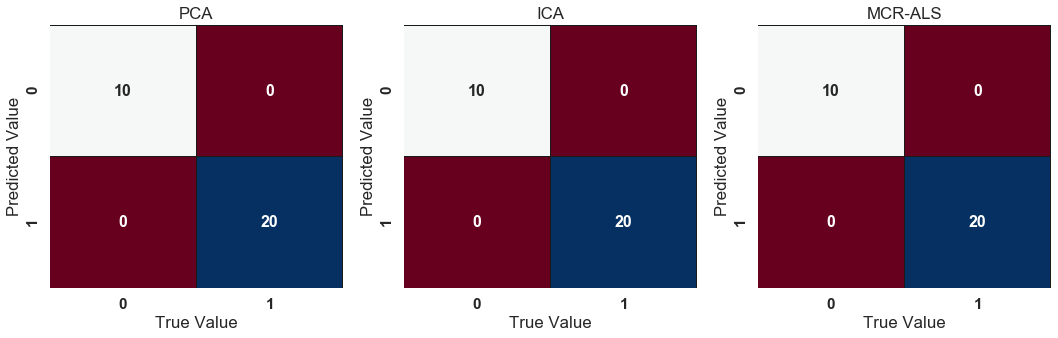

In [28]:
from sklearn.metrics import confusion_matrix

cm_pca = confusion_matrix(y_test_all,y_predict_pca)
cm_ica = confusion_matrix(y_test_all,y_predict_ica)
cm_mcr = confusion_matrix(y_test_all,y_predict_mcr)

df_cm = pd.DataFrame(cm_pca)

cmap = "binary" #set colormap
sns.set(font_scale=1.4) # for label size

fig, ax = plt.subplots(1,3,figsize=(15,5))

def plot_cm(cm, cmap = "RdBu"):
    sns.heatmap(pd.DataFrame(cm),
                annot=True,
                annot_kws={"size": 16}, 
                cmap=cmap, 
                cbar = False,
                linewidths=.5,
                linecolor = 'k',
                edgecolor = 'k'
    )
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    return

plt.axes(ax[0])
plt.title('PCA')
plot_cm(cm_pca) # font size

plt.axes(ax[1])
plt.title('ICA')
plot_cm(cm_ica) # font size

plt.axes(ax[2])
plt.title('MCR-ALS')
plot_cm(cm_mcr) # font size

plt.tight_layout()

We see above that all of them perform well. However, we can see from one of the cases above that MCR-ALS does a better job of getting the validation points closer to their own clusters (some validation splits may misclassify for PCA). MCR-ALS in general applies constraints that should return source components that more resemble real chemical spectra, which could be one reason for this. However, since there is such a clear difference between 'high' and 'low' spectra, the models here appear to perform pretty well.